In [84]:
import sqlite3 as sq3
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import elo
import config
import matplotlib.pyplot as plt
%matplotlib inline

conn = sq3.connect(config.mlb_db_path)
event = pd.read_sql(sql='select * from bevent where gameid like "%201%"', con=conn)

event['date'] = event['gameid'].apply(lambda x: int(x[3:]))
cut_point = 201707060
learn, test = event[event['date'] < cut_point], event[event['date'] >= cut_point]
print('Test/Learn Ratio: {}%'.format(round(float(len(test))/float(len(learn)),4)*100))

Test/Learn Ratio: 19.62%


# Teams

In [143]:
learn = learn.sort_values('date', ascending=True)

In [144]:
learn['hteam'] = learn['gameid'].apply(lambda x: x[:3])
cv = learn[['gameid','eventnum']].groupby('gameid').max().reset_index()
wl = cv.merge(learn[['gameid','eventnum','hscore','vscore','hteam','vteam']], on=['gameid','eventnum'])[['hscore','vscore','hteam','vteam']]

In [145]:
wl['winner'] = np.where(wl['hscore']>wl['vscore'],wl['hteam'],wl['vteam'])
wl['loser'] = np.where(wl['hscore']<wl['vscore'],wl['hteam'],wl['vteam'])

wl_ = wl[wl['hscore'] != wl['vscore']]

In [146]:
for i in wl_.index:
    if wl_.loc[i,'winner'] == wl_.loc[i,'hteam']:
        score_dict = [{'lose_score':wl_.loc[i,'hscore'],
                      'win_score':wl_.loc[i,'vscore']}]
        wl_.loc[i,'scoreing'] = score_dict
    else:
        score_dict = [{'lose_score':wl_.loc[i,'hscore'],
                      'win_score':wl_.loc[i,'vscore']}]
        wl_.loc[i,'scoreing'] = score_dict

In [147]:
xx = wl_[['winner','loser','scoreing']]

In [148]:
players = list(set(xx['winner'].tolist()))

(array([2., 1., 1., 0., 1., 3., 1., 2., 2., 3., 4., 4., 5., 3.]),
 array([1043.77517354, 1106.96856609, 1170.16195864, 1233.35535119,
        1296.54874375, 1359.7421363 , 1422.93552885, 1486.1289214 ,
        1549.32231395, 1612.51570651, 1675.70909906, 1738.90249161,
        1802.09588416, 1865.28927671, 1928.48266926]),
 <a list of 14 Patch objects>)

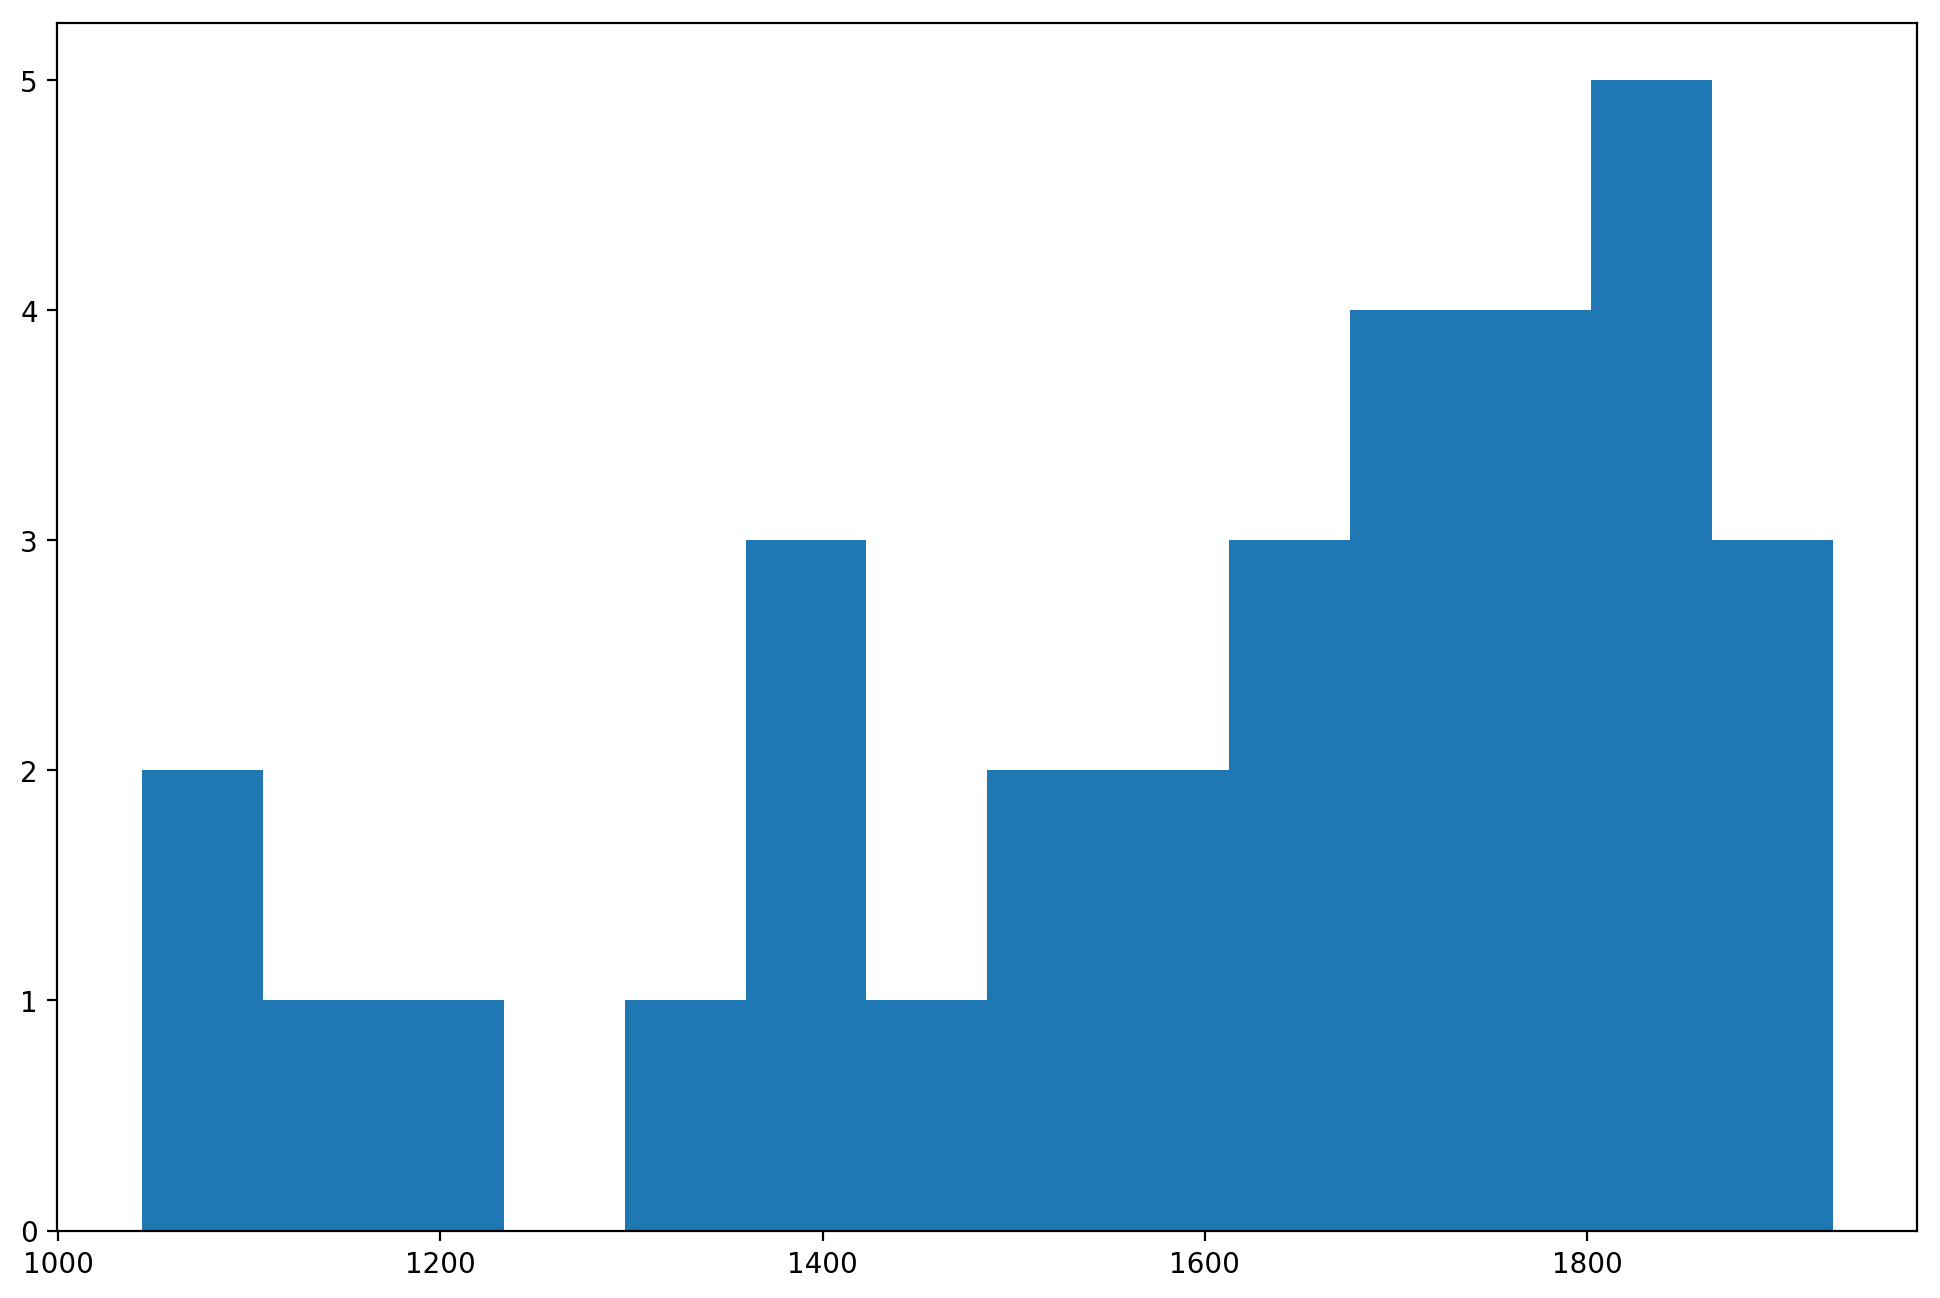

In [161]:
EL = elo.ELO(player_list=players, K=32,score_div_factor=2)
for w,l,s in zip(xx['winner'].tolist(),xx['loser'].tolist(),xx['scoreing']):
    EL.do_competition(winner=w,loser=l, scoring=s)

elo_vals = pd.DataFrame.from_dict(EL.EM.player_elo_cache, columns=['ELO'], orient='index')
EL.get_win_probibility(elo_vals['ELO'].min(),elo_vals['ELO'].max())

fig, ax1 = plt.subplots(figsize=(12,8),dpi=200)
ax1.hist(elo_vals['ELO'], bins=14)

(array([1., 2., 1., 2., 2., 1., 9., 5., 2., 1., 2., 2., 1., 1.]),
 array([1452.28662923, 1473.98206232, 1495.67749542, 1517.37292851,
        1539.0683616 , 1560.7637947 , 1582.45922779, 1604.15466089,
        1625.85009398, 1647.54552708, 1669.24096017, 1690.93639327,
        1712.63182636, 1734.32725946, 1756.02269255]),
 <a list of 14 Patch objects>)

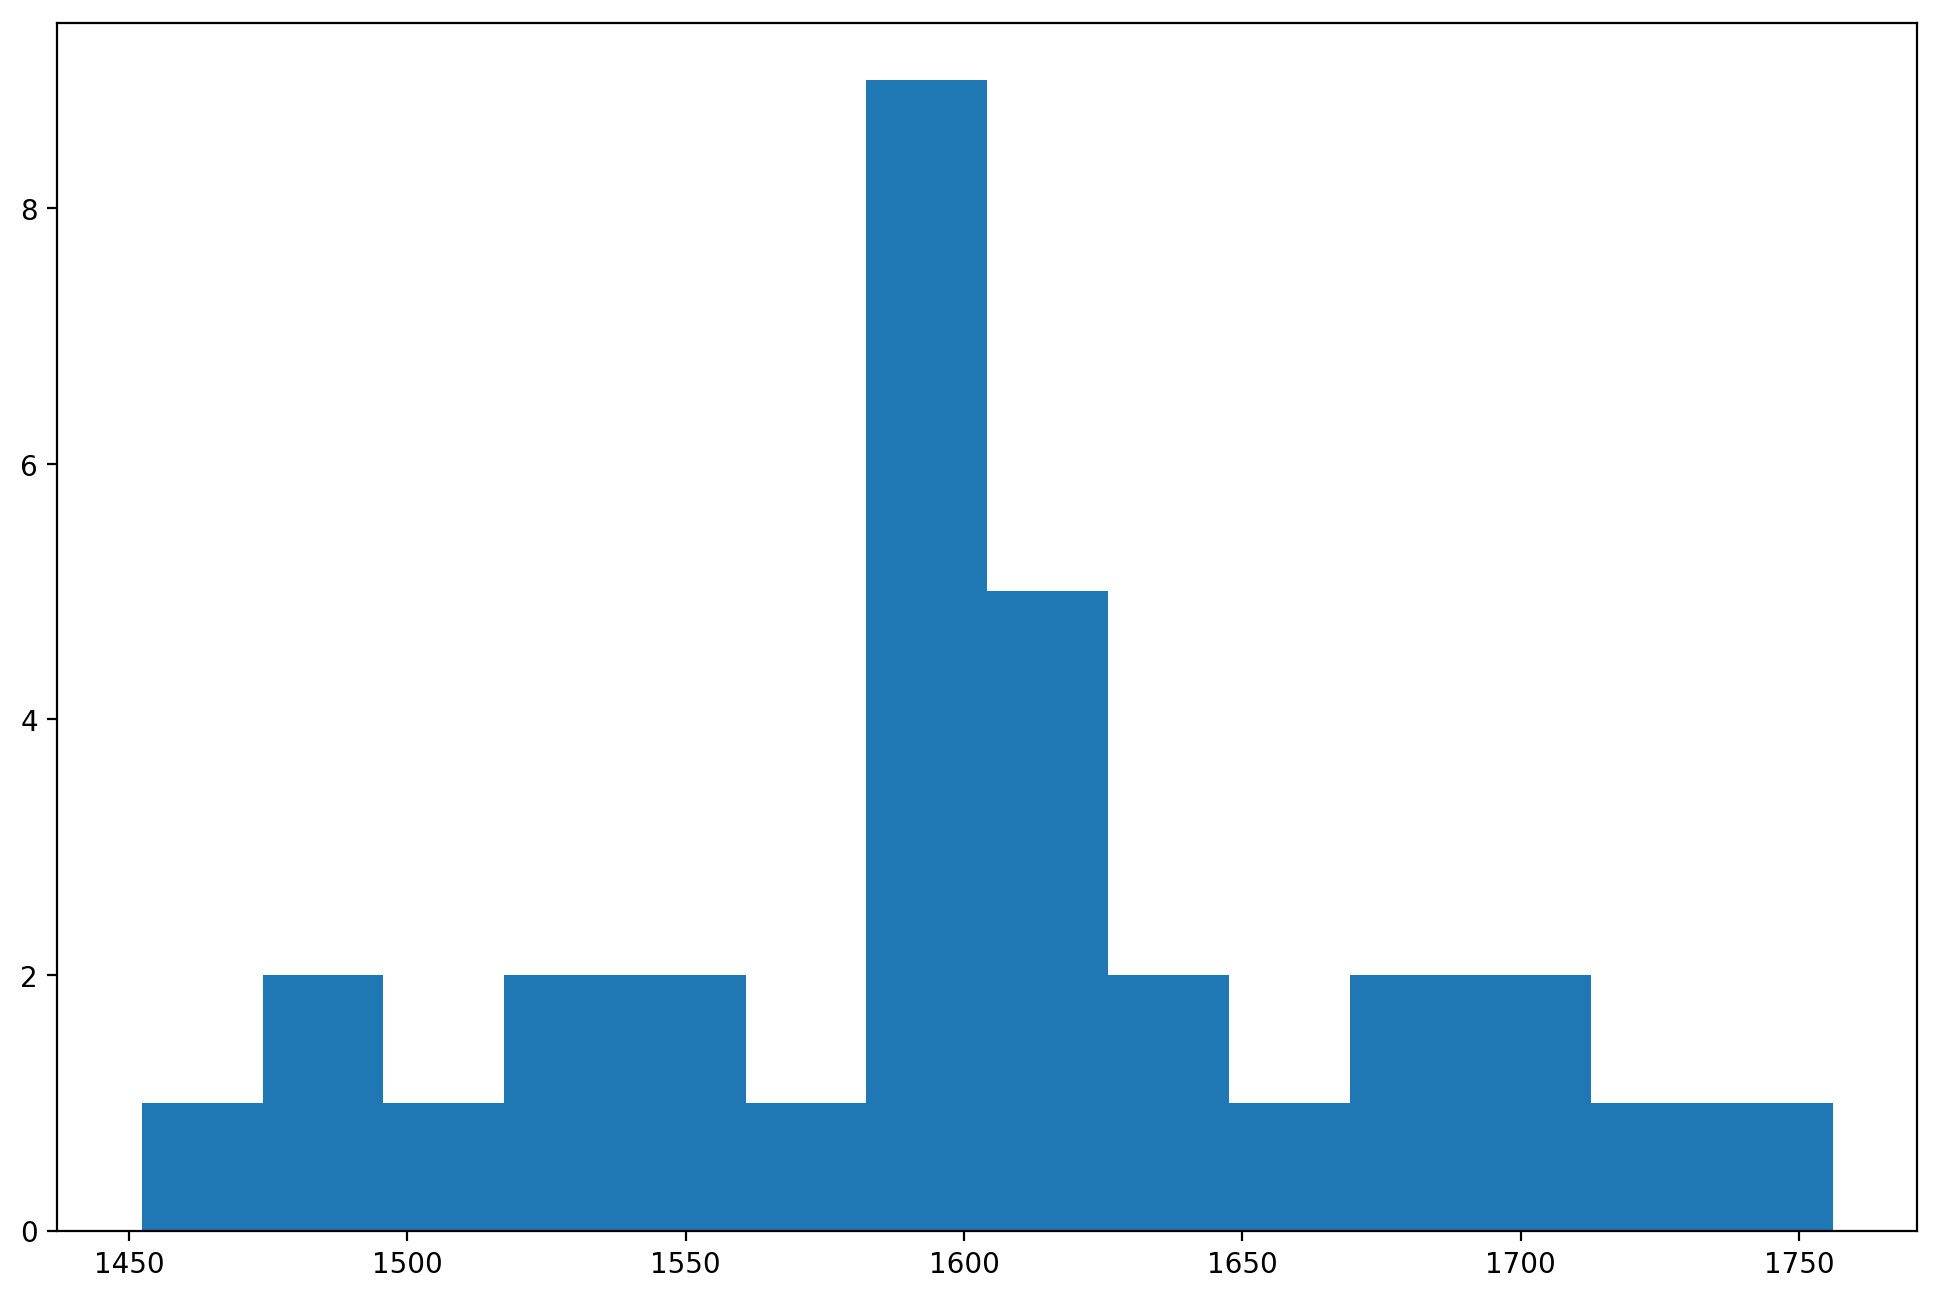

In [160]:
EL = elo.ELO(player_list=players, K=32,score_div_factor=2)
for w,l in zip(xx['winner'].tolist(),xx['loser'].tolist()):
    EL.do_competition(winner=w,loser=l)

elo_vals = pd.DataFrame.from_dict(EL.EM.player_elo_cache, columns=['ELO'], orient='index')
EL.get_win_probibility(elo_vals['ELO'].min(),elo_vals['ELO'].max())

fig, ax1 = plt.subplots(figsize=(12,8),dpi=200)
ax1.hist(elo_vals['ELO'], bins=14)

In [132]:
elo_vals.sort_values('ELO')

,ELO
WAS,906.659374
TOR,960.963843
TEX,1105.382668
SLN,1142.556584
SFN,1286.112263
SEA,1346.608665
SDN,1407.181612
TBA,1420.544971
MIN,1456.362311
MIA,1457.796333


# Players

In [10]:
import sqlite3 as sq3
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import elo
import config
import matplotlib.pyplot as plt
%matplotlib inline

conn = sq3.connect(config.mlb_db_path)
event = pd.read_sql(sql='select * from bevent where gameid like "%201%"', con=conn)
event['date'] = event['gameid'].apply(lambda x: int(x[3:]))

In [19]:
ab_s = event[event['abflag'] == 'T']
ab_s['winner'] = np.where(ab_s['hitvalue'] > 0,ab_s['batter'], ab_s['pitcher'])
ab_s['loser'] = np.where(ab_s['hitvalue'] > 0, ab_s['pitcher'], ab_s['batter'])

to_elo = ab_s[['date','winner','loser','hitvalue']]

In [26]:
def to_scoring(hv):
    if hv == 0:
        scoring = {'win_score': 1,
                   'lose_score':0}
    elif hv > 0:
        scoring = {'win_score': hv,
                   'lose_score':0}
    else:
        print(hv)
        
    return scoring

In [27]:
to_elo['scoring'] = to_elo['hitvalue'].map(to_scoring)

In [28]:
players = list(set(
    list(set(to_elo['winner'].tolist()))
   +list(set(to_elo['loser'].tolist()))
))

In [29]:
to_elo = to_elo.sort_values('date', ascending=True)

In [30]:
to_elo.head()

,date,winner,loser,hitvalue,scoring
0,199007201,appik001,boggw001,0,"{u'lose_score': 0, u'win_score': 1}"
1,199007201,appik001,reedj003,0,"{u'lose_score': 0, u'win_score': 1}"
2,199007201,appik001,quinc001,0,"{u'lose_score': 0, u'win_score': 1}"
3,199007201,seitk001,clemr001,1,"{u'lose_score': 1, u'win_score': 0}"
4,199007201,clemr001,stilk001,0,"{u'lose_score': 0, u'win_score': 1}"


In [50]:
to_elo_ = to_elo.head(2000)

In [61]:
EL = elo.ELO(player_list=players, K=32,score_div_factor=1)
for w,l in zip(to_elo['winner'].tolist(),to_elo['loser'].tolist()):
    EL.do_competition(winner=w,loser=l)

In [62]:
elo_vals = pd.DataFrame.from_dict(EL.EM.player_elo_cache, columns=['ELO'], orient='index')

In [67]:
player_lookup_b = ab_s.groupby(['batter']).agg({'date':'max'}).reset_index()
player_lookup_b['position'] = 'B'
player_lookup_p = ab_s.groupby(['pitcher']).agg({'date':'max'}).reset_index()
player_lookup_p['position'] = 'P'
player_lookup_b.rename(columns={'batter':'player'}, inplace=True)
player_lookup_p.rename(columns={'pitcher':'player'}, inplace=True)
player_lookup = player_lookup_b.append(player_lookup_p)

In [68]:
final = elo_vals.reset_index().rename(columns={'index':'player'})

In [115]:
final_ = player_lookup.merge(final, how='left',on='player')

### At Bats

In [108]:
atbats = ab_s[['batter','hitvalue']].rename(columns={'batter':'player',
                                                    'hitvalue':'abs'}
                                           ).groupby('player').count().reset_index()
atbats['position'] = 'B'

batters_faced = ab_s[['pitcher','hitvalue']].rename(columns={'pitcher':'player',
                                                    'hitvalue':'abs'}
                                                   ).groupby('player').count().reset_index()
batters_faced['position'] = 'P'

player_counts = batters_faced.append(atbats)

In [116]:
final_ = final_.merge(player_counts, how='left', on=['player','position'])

## Plotting

Plotting


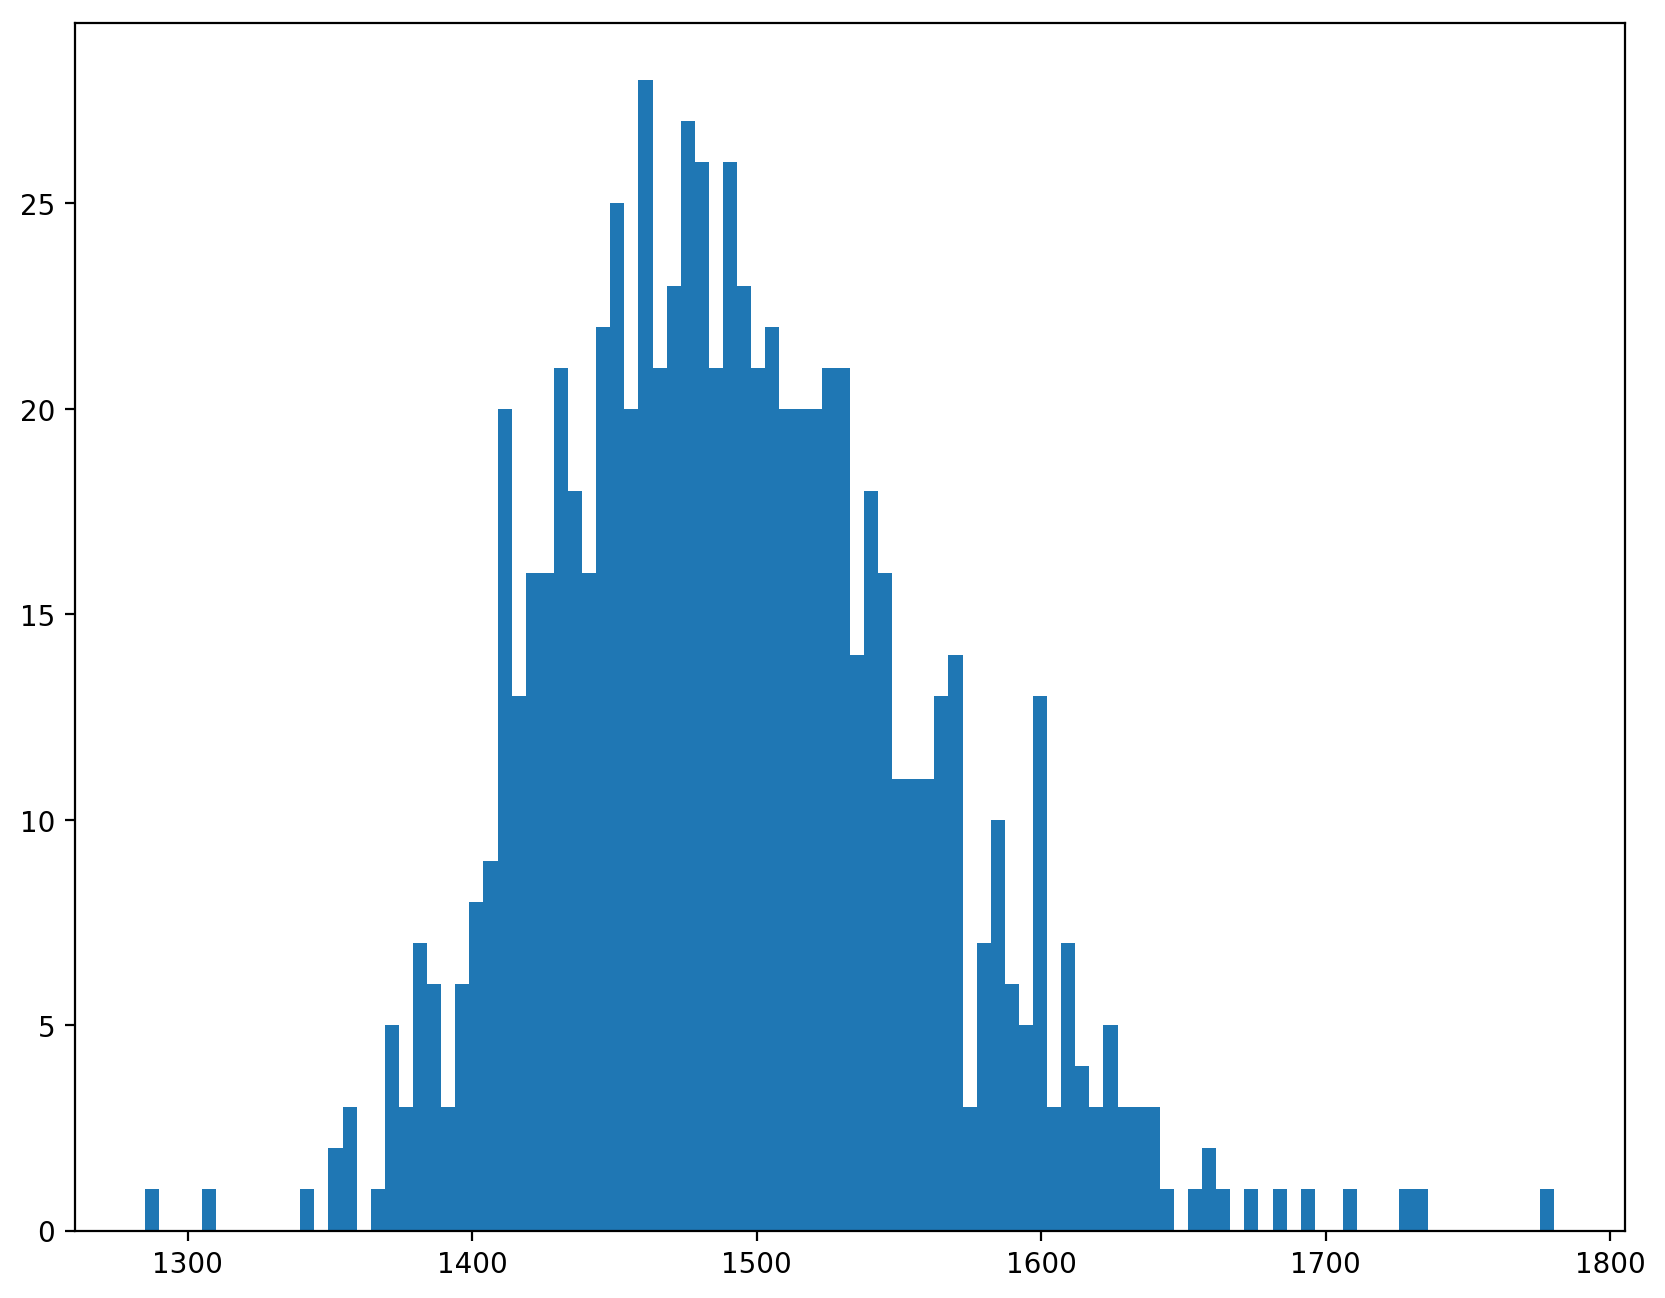

In [127]:
plotting_elo = final_[(final_['position'] == 'B') & (final_['abs'] > 400)].sort_values('ELO',ascending=False)

fig, ax1 = plt.subplots(figsize=(10,8), dpi=200)
ax1.hist(plotting_elo['ELO'], bins=100)
print('Plotting')